## Tree

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import datasets
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

X, y = datasets.fetch_openml('boston', return_X_y=True)
X = X.astype(float)
y = y.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### 1. Regression Tree

```
sklearn.tree.DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
```

Regression Tree는 오차제곱합을 가장 잘 줄일 수 있는 Feature를 기준으로 분기를 만들어 결과를 예측하는 매우 단순한 모형이다. 분기 과정에서 정보가 저장되는데, 이를 이용해 모형 추정 후 어떤 Feature가 예측에 크게 작용했는지 볼 수 있기 때문에 설명력에 있어서 다른 Machine Learning 모형보다 우월하다

최근에는 이를 이용하여 Inference를 시도하는 것이 연구되고 있다. 다만 여기서 유의할 점은, Granger Causality와 같이 예측에 있어서 특정 Feature가 큰 영향을 끼쳤다는 것을 보여줄 뿐, **인과관계를 보장하지는 않는다.** 즉, 여전히 인과관계 추론에 있어서는 **Domain Knowledge**가 매우 중요하다

아래는 Tree Model이 분기를 하는 과정을 보여준다

<center><img src = "https://www.statology.org/wp-content/uploads/2020/11/tree6.png" alt="My Image"></center>

Model자체가 분기를 포함하기 때문에, 추정된 Regression Line은 각이 진 상태로 나온다. 아래는 Regression Tree가 추정한 Line을 보여준다

<center><img src = "https://cdn-images-1.medium.com/max/1200/1*VD-ygoJ8OwUpBaTgkDTSOg.png" alt="My Image"></center>

In [6]:
from sklearn.tree import DecisionTreeRegressor

tree_regressor = DecisionTreeRegressor(
    criterion = 'squared_error',
    random_state = 42
)

tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [7]:
y_pred = tree_regressor.predict(X_test)

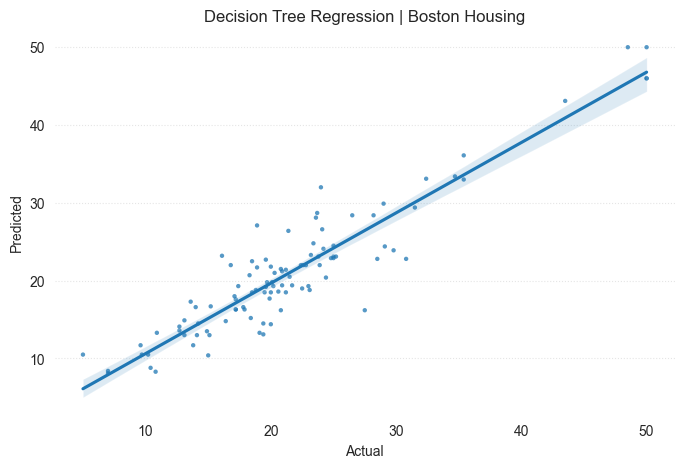

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (8, 5))
sns.regplot(
    x = y_test, 
    y = y_pred, 
    scatter_kws = {'s' : 10, 'edgecolor' : 'None', 'marker' : '.', 'alpha' : 0.75},
    ax=ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Decision Tree Regression | Boston Housing')
plt.show()

#### 1.1 Training

Regression Tree는 Top-down 방식으로 진행되며, 탐욕적 알고리즘 탐색 방식으로 가장 좋은 가지를 찾아서 분기를 하는 방식을 반복한다. 모든 변수 $X_1, X_2, \dots, X_p$와 모든 가능한 분기지점(cut point) $s$에 대해 오차 제곱합을 가장 많이 줄여주는 $(j,s)$를 선택하게 된다. Tree가 두 개의 분기로 나뉘는 초평면은 다음과 같이 정의 가능하다

$$R_1(j,s) = \{X | X_j < s\} \mathrm{~~and~~} R_2 (j,s) = \{X|X_j \geq s\}$$

다음 수식을 최소화시키는 $j$와 $s$를 구하는 식으로 분기가 이뤄진다

$$\Sigma_{i:x_i \in R_1(j,s)}(y_i - \hat{y_{R_1}})^2 + \Sigma_{i:x_i \in R_2(j,s)}(y_i - \hat{y_{R_2}})^2$$

여기서 목적이 **최소제곱**이라는 것에 주목하자. $R_1, R_2$로 구획을 나눌 때 $R_1(j,s)$에 속한 데이터들과 구획 내의 평균$\hat{y_{R_1}}$와의 차이를 구한 뒤 제곱하고, 이를 $R_2$도 마찬가지로 진행한 뒤 모두 더함으로써 오차 제곱합을 구한다

분기를 한 뒤 오차 제곱합이 분기 전 오차 제곱합보다 작아질 때까지 위 과정을 반복한다

#### 1.2 Pruning

가지치기(Pruning)는 Tree Model에서 과적합에 대응하기 위한 주요 수단이다. Tree Regression의 Hyper Parameter로는 크게 Depth와 Node의 수가 있는데, Depth와 Node의 수가 커질수록, 복잡한 모형이 된다

가지치기에는 크게 **사전 가지치기(Pre-pruning)** 와 **사후 가지치기(Post-pruning)** 이 존재한다. 사전 가지치기는 노드 분기 전 일반화 성능을 향상시킬 수 없는 것을 미리 예측하여 만약 성능 향상이 이뤄지지 않는다면, 분기를 중지하고 해당 노드를 마지막으로 학습을 끝내는 방식이다. 사후 가지치기는 모형 학습을 완료한 이후, 일반화 성능을 높이는 분기들을 삭제하는 방식으로 이뤄진다

일반적으로 사전 가지치기가 통계적 오류를 범할 실수가 적으며, 사후 가지치기는 데이터 의존적인 판단방법이 될 수 있다. sklearn에서는  `cost_complexity_pruning_path`, `ccp_alpha`를 이용해 사후 가지치기를 할 수 있으며, 사전 가지치기는 `max_depth`, `min_samples_split`, `min_samples_leaf`를 통해 지정할 수 있다

In [9]:
tree_regressor_pre = DecisionTreeRegressor(
    criterion = 'squared_error',
    max_depth = 6,
    min_samples_split = 2,
    random_state = 42
)

tree_regressor_pre.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, random_state=42)

In [10]:
y_pred = tree_regressor_pre.predict(X_test)

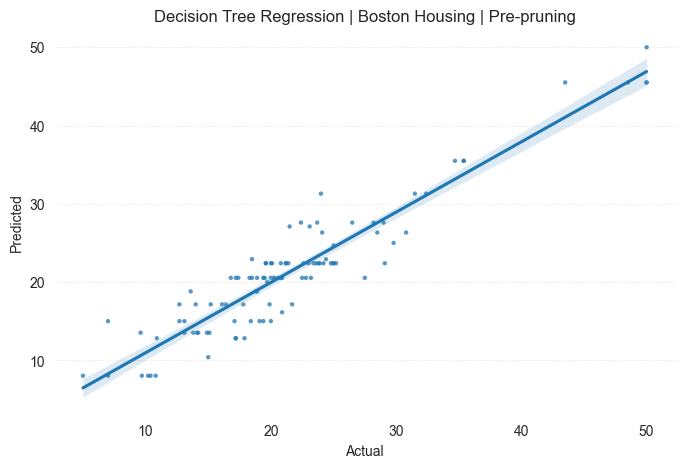

In [11]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.regplot(
    x = y_test, 
    y = y_pred, 
    scatter_kws = {'s' : 10, 'edgecolor' : 'None', 'marker' : '.', 'alpha' : 0.75},
    ax=ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Decision Tree Regression | Boston Housing | Pre-pruning')
plt.show()

In [13]:
tree_regressor_post = DecisionTreeRegressor(
    criterion = 'squared_error',
    ccp_alpha = 0.1, 
    random_state = 42
)

tree_regressor_post.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.1, random_state=42)

In [14]:
y_pred = tree_regressor_pre.predict(X_test)

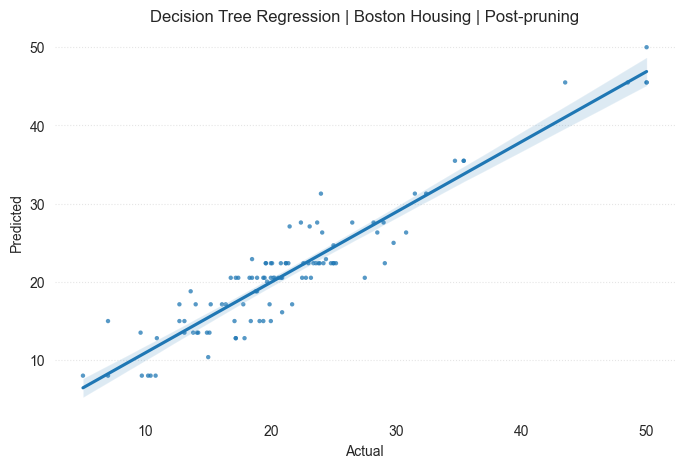

In [15]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.regplot(
    x = y_test, 
    y = y_pred, 
    scatter_kws = {'s' : 10, 'edgecolor' : 'None', 'marker' : '.', 'alpha' : 0.75},
    ax=ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Decision Tree Regression | Boston Housing | Post-pruning')
plt.show()

### 2. Tree Classifier

<center><img src = "https://i.stack.imgur.com/Qq0TC.png" alt="My Image"></center>

Tree 모형의 목적은 target 함수를 가장 잘 묘사하는 approximation을 구하는 것이다. Target(종속변수)과 feature사이의 관계를 Tree구조로 구현한 모형이라고 보면 된다

```
sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, 
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                    max_features=None, random_state=None, max_leaf_nodes=None, 
                                    min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
```

In [16]:
data = pd.read_csv('../../Data/Credit_card_data.csv', index_col = 0)

data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [17]:
X = data.drop(['default.payment.next.month'], axis = 1)
y = data['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#### 2.1 분기의 결정

Tree Model의 분기는 분기를 했을 때 모형의 오차가 작아지는 양이 큰 방향으로 진행되는데, 이 기준을 **Information Gain(정보 이득)** 이라고 한다

$$\mathrm{Information~Gain}(S, A) = \mathrm{IG}(S, A) = H(S) - H(S|A)$$

정보 이득을 계산하기 위한 방법으로는 **Gini Impurity(지니 불순도)** 와 **Entropy**가 있다

$$\mathrm{Gini}(\pi) = \sum_{c=1}^C \Big( \pi_c (\sum_{i \neq c} \pi_i)\Big) = \sum_{c=1}^C \pi_c - \sum_{c=1}^C \pi_c^2 = 1 - \sum_{c=1}^C \pi_c^2$$
$$\mathrm{Gini~Gain~=~Gini~Impurity~before~split - Gini~Impurity~after~split}$$



$$\mathrm{Entropy} = H(Y|X) = -\sum_{x} p(x) \sum_{x} H(Y| X = x)$$
$$\mathrm{Entropy~Gain~=~Entropy~Impurity~before~split - Entropy~Impurity~after~split}$$

즉, 두 정보 기준의 최적화 문제는 Information Gain의 극대화 문제와 동일한 해를 가진다

<center><img src = "https://ekamperi.github.io/images/decision_trees/gini_vs_entropy.png" alt="My Image"></center>

Impurity Measure를 비교하면 0부터 1까지 정의된 모든 확률 구간에서 Entropy가 크게 측정된다. 즉, threshold가 낮은 구간에서 Gini Impurity에 비해 Entropy가 더 분기에 강건한 경향을 보인다

In [26]:
from sklearn.tree import DecisionTreeClassifier

tree_classification = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth = 6,
    min_samples_split = 2,
    random_state = 42
)

tree_classification.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [27]:
y_pred = tree_classification.predict(X_test)
y_prob = tree_classification.predict_proba(X_test)

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7040
           1       0.65      0.37      0.47      1960

    accuracy                           0.82      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000



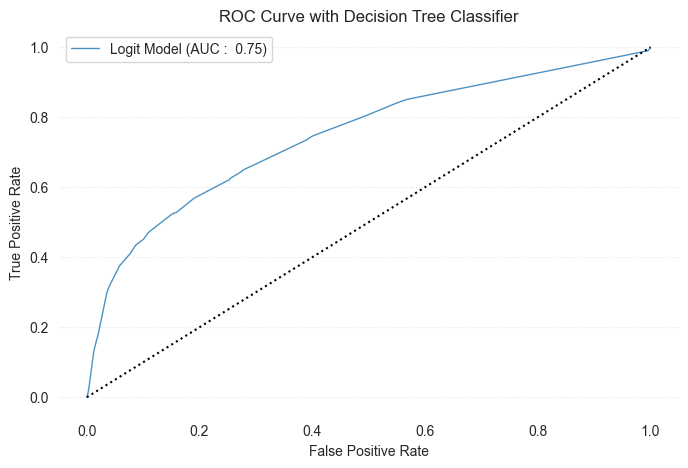

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(fpr, tpr, label = f'Logit Model (AUC : {roc_auc : .2f})', alpha = 0.8, lw = 1)
ax.plot([0, 1], [0, 1], 'k:')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('ROC Curve with Decision Tree Classifier')
plt.show()

#### 2.2 Feature Importance

Tree의 특징을 생각해 볼 때, 어떤 Node와 해당 Children Node 사이의 정보량에 별 차이가 없다면 그 Node에 할당된 attribute는 적어도 그 위치에서는 분류에 기여하는 바가 없다고 볼 수 있다. 이 경우, feature importance는 0으로 계산된다. 

분기를 할 때마다 어떤 feature를 기준으로 분기를 하였는지 저장을 하는데, 이 저장된 데이터를 모형 추정 이후에 보는 것을 **특성 중요도(feature importance)** 라고 한다

Children Node의 수가 두 개일 경우 node의 중요도는 다음과 같이 계산할 수 있다

$$
f_{kj}=
\begin{cases}
\frac{n_j}{n} \left(g_j - \frac{n_{jL}}{n_j} g_{jL} - \frac{n_{jR}}{n_j} g_{j,R} \right), & \mbox{    if }x_k\mbox{ is assigned to node } j \\
0, & \mbox{    otherwise}
\end{cases}
$$

여기서 $f_{kj}$는 노드 j에 배정된 feature $k$의 중요성이고, $g$는 information gain이다. $R$과 $L$은 각각 분기시 오른쪽 자식 노드와 왼쪽 자식 노드를 의미한다. Feature k가 지정된 모든 node들의 중요도를 더해 feature k의 중요도를 계산한다

$$f_k = \frac{\Sigma_{j}f_{kj}}{\Sigma_k \Sigma_j f_{kj}}$$

Decision Tree를 비롯하여 Tree기반 Ensemble 모형은 모두 attribute에 대해서 상대적 중요성을 확인할 수 있다. Feature Selection 용도로 확인할 수 있으며, 최근 특성 중요도를 응용하여 추론을 시도하는 연구가 이뤄지고 있다

In [41]:
importance = pd.Series(
    tree_classification.feature_importances_,
    index = X_train.columns
).sort_values(ascending = True)

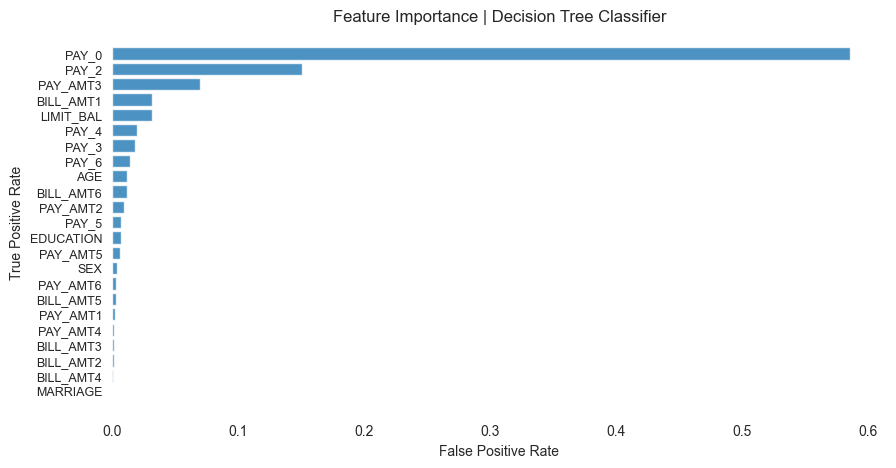

In [46]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.barh(
    importance.index,
    importance,
    alpha = 0.8
)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.yticks(fontsize = 9)

plt.title('Feature Importance | Decision Tree Classifier')
plt.show()